In [1]:
import polars as pl
import os
import humanize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the large DataFrame
lf = pl.scan_csv("../../datasets/hansard_c19_updated.csv")

lf.collect_schema()

Schema([('sentence_id', String),
        ('src_file_id', String),
        ('speech_id', Int64),
        ('debate_id', Int64),
        ('speechdate', String),
        ('debate', String),
        ('text', String),
        ('speaker', String),
        ('speaker_house', String),
        ('src_image', String),
        ('new_speaker', String),
        ('decade', Int64)])

In [3]:
# Select only relevant columns
df = (
    lf
        .select(["text", "new_speaker"])
        .collect()
)

df

text,new_speaker
str,str
"""moved that Lord Walsingham be …","""unknown"""
"""in seconding the motion, took …","""john_scott_6733"""
"""—The question was put, and the…","""john_scott_6733"""
"""then rose, and observed, that …","""unknown"""
"""He had to return his thanks to…","""unknown"""
…,…
"""Under the existing law, with a…","""robert_reid_5702"""
"""This control, and the controls…","""robert_reid_5702"""
"""A review is being held of the …","""robert_reid_5702"""


In [4]:
df_plot = df.with_columns(length = pl.col("text").str.count_matches("[^ ]+")).to_pandas()
df_plot

,text,new_speaker,length
0,moved that Lord Walsingham be appointed chairm...,unknown,16
1,"in seconding the motion, took an opportunity t...",john_scott_6733,46
2,"—The question was put, and the appointment for...",john_scott_6733,14
3,"then rose, and observed, that he was not in th...",unknown,52
4,He had to return his thanks to the House for t...,unknown,77
...,...,...,...
10979004,"Under the existing law, with a few well-define...",robert_reid_5702,33
10979005,"This control, and the controls on sale and tra...",robert_reid_5702,13
10979006,A review is being held of the law relating to ...,robert_reid_5702,14
10979007,asked Her Majesty's Government:,unknown,4


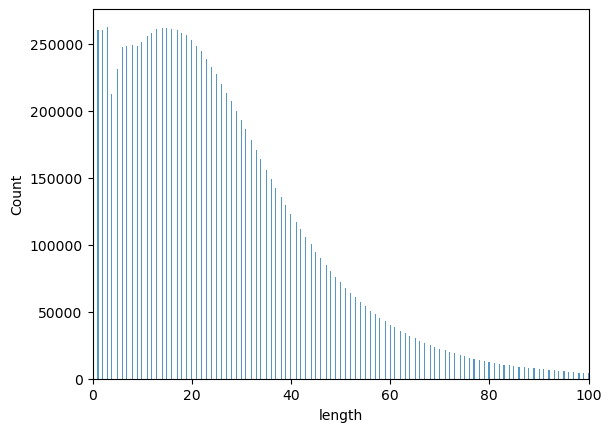

In [5]:
sns.histplot(
    df_plot, 
    x = "length"
)

plt.xlim((0, 100))
plt.show()

In [6]:
# Determine approximate size of each row in bytes
outfile = "full_dataset.csv"
df.write_csv(outfile)
row_size = os.path.getsize(outfile) / len(df)
os.remove(outfile)  # Clean up the sample file

row_size

170.0066604372034

In [8]:
filesizes = [
    "10 kb",
    "100 kb",
    "500 kb",
    "1 mb",
    "10 mb",
    "100 mb",
    "250 mb",
    "500 mb",
    "750 mb",
    "1 gb",
]

In [9]:
# Create subsets of each file size
for size_str in filesizes:
    units = size_str[-2:]
    num = int(size_str.replace(units, "").strip())
    if units == "kb":
        size_bytes = num * 1028
    elif units == "mb":
        size_bytes = num * 1028 * 1028
    elif units == "gb":
        size_bytes = num * 1028 * 1028 * 1028
    else:
        print(f"Unrecognized units: { units }")
        continue
    
    nrows = int(size_bytes / row_size)
    df_subset = df.head(nrows)
    filename = f"subsets/subset_{ units }_{ num }.csv"
    df_subset.write_csv(filename)
    
    actual_size = os.path.getsize(filename)
    error = round(100 * ((actual_size - size_bytes) / size_bytes), 1)
    print(f"{ size_str }: { humanize.intcomma(nrows) } rows with actual size { humanize.naturalsize(actual_size ).lower() } = { error }% error")

10 kb: 60 rows with actual size 12.7 kb = 23.8% error
100 kb: 604 rows with actual size 118.1 kb = 14.9% error
500 kb: 3,023 rows with actual size 582.0 kb = 13.2% error
1 mb: 6,216 rows with actual size 1.2 mb = 9.3% error
10 mb: 62,161 rows with actual size 11.5 mb = 8.4% error
100 mb: 621,613 rows with actual size 114.4 mb = 8.2% error
250 mb: 1,554,033 rows with actual size 284.2 mb = 7.6% error
500 mb: 3,108,066 rows with actual size 570.6 mb = 8.0% error
750 mb: 4,662,099 rows with actual size 855.8 mb = 8.0% error
1 gb: 6,390,184 rows with actual size 1.2 gb = 6.7% error
